In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import expipe
import os
import pathlib
import numpy as np
import exdir
import pandas as pd
import optogenetics as og
import quantities as pq
import shutil
from distutils.dir_util import copy_tree

from septum_mec.analysis.stimulus_response import stimulus_response_latency, compute_response

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

10:17:24 [I] klustakwik KlustaKwik2 version 0.2.6
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


In [3]:
std_gaussian_kde = 0.04
window_size = 0.03

In [4]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [5]:
output = pathlib.Path('output/stimulus-response')
(output / 'data').mkdir(parents=True, exist_ok=True)

In [6]:
# identify_neurons = actions['identify-neurons']
# units = pd.read_csv(identify_neurons.data_path('units'))

In [9]:
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')

In [22]:
units

,action,channel_group,max_depth_delta,max_dissimilarity,unit_id,unit_idnum,unit_name
0,1834-010319-1,0,100,0.05,ae0353a9-a406-409e-8ff7-2e940b8af03f,327,2
1,1834-010319-1,0,100,0.05,7f514d43-17ba-4d88-a390-20eec8bc1378,328,39
2,1834-010319-3,0,100,0.05,c977aa51-06cc-4d54-9430-a94ad422a03b,329,1
3,1834-010319-3,0,100,0.05,bd96a67d-ee7d-4cb6-90ab-a5fa751891b9,330,12
4,1834-010319-4,0,100,0.05,abc01041-2971-4f62-bf06-5132cf356737,332,7
...,...,...,...,...,...,...,...
1279,1839-290519-1,7,100,0.05,b10850fc-77de-4a20-9d65-43065035b1c2,668,87
1280,1839-290519-2,7,100,0.05,b42cb814-9a61-431a-9a39-e7a68a000283,669,109
1281,1839-290519-2,7,100,0.05,caf4bddf-9665-499b-9622-132732716437,670,111
1282,1839-290519-2,7,100,0.05,e81bcac4-0a42-4c9d-9088-5878f550809d,671,135


In [16]:
stim_resp = actions["stimulus-response"]
# stim_resp = pd.read_csv(identification_action.data_path('stimulus_response'))


In [18]:
stim_res = pd.read_csv(stim_resp.data_path("results"))

In [23]:
len(stim_res)
# use p_e_peak < 0.05

1298

In [27]:
len(stim_res[stim_res.p_e_peak < 0.05])

229

In [11]:
session_units_stim = session_units[session_units.baseline == False]
# baseline False / groupby frequency

In [21]:
len(session_units_stim)

660

In [7]:
# def process(row):
    
#     action_id = row['action']
#     channel_id = int(row['channel_group'])
#     unit_id = int(row['unit_name'])    
    
#     spike_times = data_loader.spike_train(action_id, channel_id, unit_id)
    
#     spike_times = np.array(spike_times)
    
#     stim_times = data_loader.stim_times(action_id)
    
#     nan_series = pd.Series({
#             't_e_peak': np.nan,
#             'p_e_peak': np.nan,
#             't_i_peak': np.nan,
#             'p_i_peak': np.nan
#         })
    
#     if stim_times is None:
#         return nan_series
    
#     stim_times = np.array(stim_times)
    
#     times, spikes, kernel, p_e, p_i = stimulus_response_latency(
#         spike_times, stim_times, window_size, std_gaussian_kde)
    
#     # if no spikes detected after stimulus nan is returned
#     if all(np.isnan([p_e, p_i])):
#         return nan_series
        
#     t_e_peak, p_e_peak, t_i_peak, p_i_peak = compute_response(
#         spike_times, stim_times, times, kernel, p_e, p_i)

#     return pd.Series({
#         't_e_peak': t_e_peak,
#         'p_e_peak': p_e_peak,
#         't_i_peak': t_i_peak,
#         'p_i_peak': p_i_peak
#     })




In [8]:
results = units.merge(
    units.progress_apply(process, axis=1), 
    left_index=True, right_index=True)

/home/mikkel/apps/expipe-project/septum-mec/septum_mec/analysis/stimulus_response.py:33: RuntimeWarning: invalid value encountered in less
  if any(times[idxs_i] < te_peak):


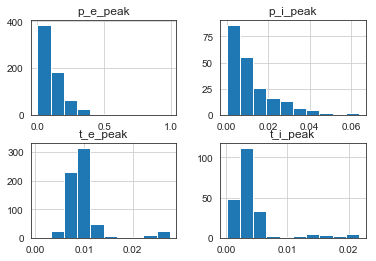

In [9]:
results.loc[:, ['t_e_peak', 't_i_peak', 'p_e_peak', 'p_i_peak']].hist()
plt.gcf().savefig(output / 'figures' / 'summary_histogram.png')

In [8]:
psth, time = {}, {}
for i, row in tqdm(units.iterrows(), total=len(units)):
    action_id = row['action']
    channel_group = row['channel_group']
    unit_name = row['unit_name']
    name = f'{action_id}_{channel_group}_{unit_name}'
    spike_times = data_loader.spike_train(action_id, channel_group, unit_name)
    
    spike_times = np.array(spike_times)
    
    stim_times = data_loader.stim_times(action_id)
    
    if stim_times is None:
        continue
    
    stim_times = np.array(stim_times)
    
    _, spikes, kernel, p_e, p_i = stimulus_response_latency(
        spike_times, stim_times, window_size, std_gaussian_kde)
    
    if all(np.isnan([p_e, p_i])):
        continue
    times = np.arange(-0.005, window_size, 1e-4)
    psth.update({name: kernel(times)})
    time.update({name: times})

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [28]:
psth_df = pd.read_feather(output / 'data' / 'psth.feather')

In [30]:
len(psth_df)

350

In [9]:
pd.DataFrame(psth).to_feather(output / 'data' / 'psth.feather')
pd.DataFrame(time).to_feather(output / 'data' / 'times.feather')

# Save to expipe

In [27]:
action = project.require_action("stimulus-response")

In [11]:
action.modules['parameters'] = {
    'window_size': window_size,
    'std_gaussian_kde': std_gaussian_kde
}

In [12]:
action.data['results'] = 'results.csv'
results.to_csv(action.data_path('results'), index=False)

In [28]:
copy_tree(output, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/stimulus-response/data/data/times.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-response/data/data/psth.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-response/data/figures/summary_histogram.png']

In [29]:
septum_mec.analysis.registration.store_notebook(action, "10-calculate-stimulus-response.ipynb")